**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score

from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse.csr import csr_matrix

#### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors=5, algorithm='brute', metric='minkowski'):
        BaseEstimator.__init__(self)
        self._n_neighbors = n_neighbors
        self._algorithm = algorithm
        self._metric = metric
        self._train_x = None
        self._train_y = None
        self._train_x_tree = None
        self._classes = None
        
    def fit(self, X, Y):
        if self._algorithm == 'brute':
            self._train_x = X
            
        elif self._algorithm == 'kd_tree':
            self._train_x_tree = KDTree(X, metric=self._metric)
        self._train_y = Y
        self._classes = np.sort(np.unique(Y))
        
    def get_k_neighbors_indexes(self, x_array):
        if self._algorithm == "brute":
            metric = 'euclidean' if self._metric != 'cosine' else 'cosine'
            return np.argpartition( pairwise_distances(
                    X=x_array, Y=self._train_x, metric=metric),
                self._n_neighbors - 1 )[::, :self._n_neighbors:]
        
        elif self._algorithm == 'kd_tree':
            return self._train_x_tree.query(x_array, k=self._n_neighbors, return_distance=False)
        
    def predict(self, X):
        indexes = self.get_k_neighbors_indexes(X)
        y_closest = np.apply_along_axis(lambda ind: self._train_y[ind], -1, indexes)
        def most_frequent(array):
            value, count = np.unique(array, return_counts=True)
            return value[np.argmax(count)]

        return np.apply_along_axis(most_frequent, -1, y_closest)
    
    def score(self, x_test, y_test, sample_weight=None):
        return (self.predict(x_test) == y_test).sum() / y_test.shape[0]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%timeit clf.fit(X_train, y_train)

138 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%timeit my_clf.fit(X_train, y_train)

8.08 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit clf.predict(X_test)

632 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit my_clf.predict(X_test)

544 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [16]:
%time clf.predict(X_test)

Wall time: 1.96 ms


array([2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0])

In [17]:
%time my_clf.predict(X_test)

Wall time: 2.99 ms


array([2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
 from sklearn.model_selection import KFold

In [24]:
kf = KFold(n_splits=3, shuffle = True)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [25]:
def get_average_score(X, Y, kf, n_neighbors, metric):
    sum_score = 0.0
    for train_index, test_index in kf.split(X):
        clf = MyKNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute', metric=metric)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, np.asarray(Y_train))
        sum_score += clf.score(X_test, Y_test)

    return sum_score / kf.get_n_splits()

def get_avarage_score_array(x, y, kf, metric, kmax):
    a = []
    for k in range(1, kmax + 1):
        a.append(get_average_score(x, y, kf, k, metric))
    return np.asarray(a)

,n_neighbors,score
0,1,0.208768
7,8,0.195864
8,9,0.193123
9,10,0.193035
5,6,0.186848


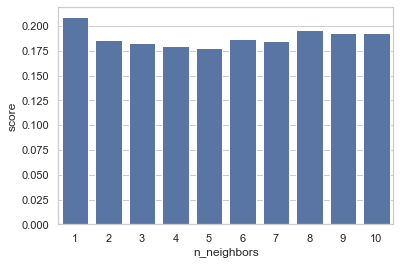

In [26]:
scores = get_avarage_score_array(X, target, kf,'minkowski', 10)
df = pd.DataFrame(data=zip(range(1, 11), scores), columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')
df.sort_values("score", ascending=False).head()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

,n_neighbors,score
0,1,0.206558
9,10,0.190560
8,9,0.188969
6,7,0.187113
5,6,0.186141


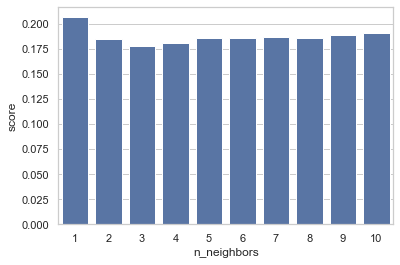

In [52]:
scores = get_avarage_score_array(X, target, kf,'minkowski', 10)
df = pd.DataFrame(data=zip(range(1, 11), scores), columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')
df.sort_values("score", ascending=False).head()

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

In [28]:
transformer = TfidfTransformer()
t_docs = transformer.fit_transform(X, target)

,n_neighbors,score
0,1,0.151405
3,4,0.102704
1,2,0.101999
7,8,0.094927
4,5,0.094661


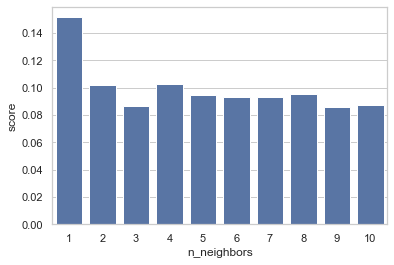

In [29]:
scores = get_avarage_score_array(t_docs, target, kf, 'minkowski', 10)
df = pd.DataFrame(data=zip(range(1, 11), scores), columns=['n_neighbors', 'score'])
sns.set(style="whitegrid")
sns.barplot(x="n_neighbors", y="score", data=df, color='b')
df.sort_values("score", ascending=False).head()

Класс!

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [38]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [39]:
data_test = newsgroups['data']
target_test = newsgroups['target']
X2 = vectorizer.fit_transform(data_test)

In [40]:
test_docs = transformer.fit_transform(X2, target)

In [41]:
clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='minkowski')
clf.fit(t_docs, target)
clf.score(test_docs, target_test)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 71018 while Y.shape[1] == 101631